In [ ]:
from pathlib import Path

import numpy as np
import time
import matplotlib.pyplot as plt

import librosa
import soundfile as sf
from scipy.io import wavfile

In [ ]:
jaar_files = []

folder_path = Path('JaarSongs/1-SpaceIsOnlyNoise(2011)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/2-Nymphs(2011-2015)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/3-Pomegranates(2015)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/4-Sirens(2016)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/5-Cenizas(2020)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

folder_path = Path('JaarSongs/6-Telas(2020)')
files = [file for file in folder_path.iterdir() if file.suffix=='.wav']
for file in sorted(files, key = lambda x: x.name):
    jaar_files.append(file)

print(len(jaar_files))

66


In [ ]:
import time

all_mid_side = []
all_mono = []
sample_rate = 44100

start_time = time.time()
for i in range(len(jaar_files)):
    y, _ = librosa.load(jaar_files[i], sr=sample_rate, mono=False)
    mid = 0.5 * (y[0, :] + y[1, :])
    side = 0.5 * (y[0, :] - y[1, :])
    all_mid_side.append(np.array([mid, side]).T)
    all_mono.append(librosa.to_mono(y))
end_time = time.time()

print(end_time - start_time)

17.08659291267395


In [ ]:
all_mono[0].shape, all_mid_side[0].shape, all_mono[0][0:1], len(all_mid_side)

((12747263,), (12747263, 2), array([-1.5258789e-05], dtype=float32), 66)

In [ ]:
window_sample_number = 30*sample_rate

indexes = []
all_mid_side_chopped = []
all_mono_chopped = []

start_time = time.time()
for i in range(len(all_mid_side)):
    offset = 0
    while offset + window_sample_number <= all_mid_side[i].shape[0]:
        all_mid_side_chopped.append(all_mid_side[i][offset : offset+window_sample_number, :])
        all_mono_chopped.append(all_mono[i][offset : offset+window_sample_number])
        indexes.append(i)
        offset += window_sample_number
end_time = time.time()

print(end_time - start_time)
len(all_mid_side_chopped), len(all_mono_chopped), len(indexes)

0.000926971435546875


(650, 650, 650)

In [ ]:
MS_array = np.array(all_mid_side_chopped)
mono_array = np.array(all_mono_chopped)
index_array = np.array(indexes)
MS_array.shape, mono_array.shape, index_array.shape

((650, 1323000, 2), (650, 1323000), (650,))

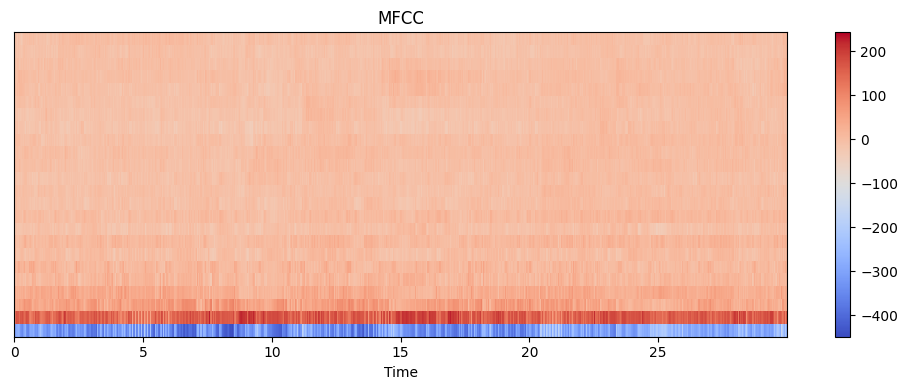

((24, 2584), 62016)

In [ ]:
n_mfcc = 24  # Number of MFCC coefficients to calculate
mfccs = librosa.feature.mfcc(y=MS_array[72,:,0], sr=sample_rate, n_mfcc=n_mfcc)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

mfccs.shape, mfccs.size # It's a lot smaller!

In [ ]:
new_MS_dims = [MS_array.shape[0], MS_array.shape[2], mfccs.shape[0], mfccs.shape[1]]
new_mono_dims = [mono_array.shape[0], mfccs.shape[0], mfccs.shape[1]]
MS_mfcc = np.zeros(shape=new_MS_dims)
mono_mfcc = np.zeros(shape=new_mono_dims)

start_time = time.time()
for i in range(MS_mfcc.shape[0]):
    MS_mfcc[i,0] = librosa.feature.mfcc(y=MS_array[i,:,0], sr=sample_rate, n_mfcc=n_mfcc)
    MS_mfcc[i,1] = librosa.feature.mfcc(y=MS_array[i,:,1], sr=sample_rate, n_mfcc=n_mfcc)
for i in range(mono_mfcc.shape[0]):
    mono_mfcc[i] = librosa.feature.mfcc(y=mono_array[i,:], sr=sample_rate, n_mfcc=n_mfcc)
end_time = time.time()

print(end_time - start_time)
MS_mfcc.shape, mono_mfcc.shape

122.04502725601196


((650, 2, 24, 2584), (650, 24, 2584))

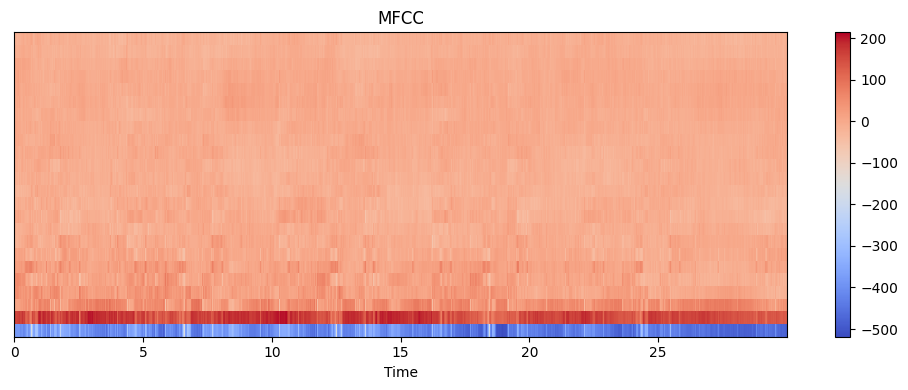

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mono_mfcc[649], sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

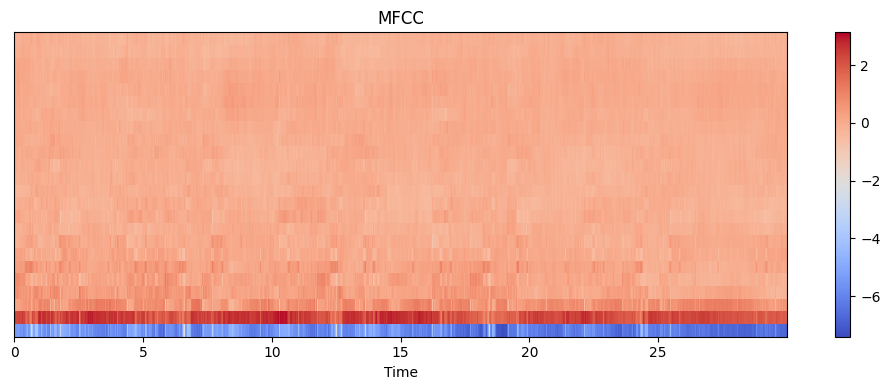

In [ ]:
means = np.mean(MS_mfcc, axis=(0, 1))
standard_deviations = np.std(MS_mfcc, axis=(0, 1))
# Perform Z-score normalization for each channel separately
MS_mfcc_normed = (MS_mfcc - means) / standard_deviations

means = np.mean(mono_mfcc, axis=(0, 1))
standard_deviations = np.std(mono_mfcc, axis=(0, 1))
# Perform Z-score normalization on mono
mono_mfcc_normed = (mono_mfcc - means) / standard_deviations

plt.figure(figsize=(10, 4))
librosa.display.specshow(mono_mfcc_normed[649], sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

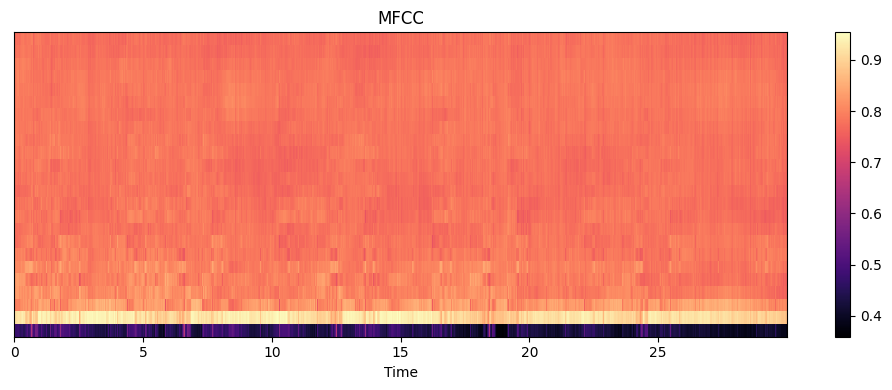

In [ ]:
min_values = np.min(MS_mfcc_normed, axis=(0, 1))
max_values = np.max(MS_mfcc_normed, axis=(0, 1))
MS_mfcc_normedz = (MS_mfcc_normed - min_values) / (max_values - min_values)

min_values = np.min(mono_mfcc_normed, axis=(0, 1))
max_values = np.max(mono_mfcc_normed, axis=(0, 1))
mono_mfcc_normedz = (mono_mfcc_normed - min_values) / (max_values - min_values)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mono_mfcc_normedz[649], sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [ ]:
import pickle

with open('MS_mfcc_normedz_44100.pkl', 'wb') as file:
    pickle.dump(MS_mfcc, file)
with open('mono_mfcc_normedz_44100.pkl', 'wb') as file:
    pickle.dump(mono_mfcc, file)
with open('mfcc_indexes.pkl', 'wb') as file:
    pickle.dump(index_array, file)

In [ ]:
#mono_mfcc[649]

In [ ]:
# min_values = np.min(mono_mfcc, axis=(0, 1))
# max_values = np.max(mono_mfcc, axis=(0, 1))

# # Perform Min-Max normalization for each channel separately
# normalized_data = (mono_mfcc - min_values) / (max_values - min_values)


# mean_values = np.mean(MS_mfcc, axis=(0, 1))
# standard_deviations = np.std(MS_mfcc, axis=(0, 1))

# # Perform Z-score normalization for each channel separately
# normalized_data_SD = (MS_mfcc - mean_values) / standard_deviations

# # normalized_data[0], normalized_data_SD[0]
# normalized_data_SD[0].shape